In [1]:
import sys
import os

# Add the project root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from src.drift_detector import DriftDetector

# Load the Drift Engine
detector = DriftDetector()

# Load the Datasets
df_baseline = pd.read_csv('../data/processed/baseline_stable.csv')
df_stable = pd.read_csv('../data/processed/future_unseen.csv')
df_sensor = pd.read_csv('../data/processed/future_sensor_decay.csv')
df_concept = pd.read_csv('../data/processed/future_concept_drift.csv')

# Load Model Metadata
features = joblib.load('../models/feature_list.pkl')
model = joblib.load('../models/golden_model.pkl')

In [2]:
print("🔬 AUDIT 1: Testing Stable 'Future' Data (Expected: STABLE)")
report_stable = detector.generate_feature_drift_report(df_baseline, df_stable, features)
print(report_stable[report_stable['Audit_Status'] == 'DRIFT'])

print("\n🔬 AUDIT 2: Testing Sensor Decay (Expected: DRIFT in housing_median_age)")
report_sensor = detector.generate_feature_drift_report(df_baseline, df_sensor, features)
print(report_sensor[report_sensor['Audit_Status'] == 'DRIFT'])

print("\n🔬 AUDIT 3: Testing Concept Drift (Expected: DRIFT in median_income)")
report_concept = detector.generate_feature_drift_report(df_baseline, df_concept, features)
print(report_concept[report_concept['Audit_Status'] == 'DRIFT'])

🔬 AUDIT 1: Testing Stable 'Future' Data (Expected: STABLE)
Empty DataFrame
Columns: [Feature, PSI_Score, KS_P_Value, Audit_Status]
Index: []

🔬 AUDIT 2: Testing Sensor Decay (Expected: DRIFT in housing_median_age)
              Feature  PSI_Score  KS_P_Value Audit_Status
2  housing_median_age     0.0056     0.00003        DRIFT

🔬 AUDIT 3: Testing Concept Drift (Expected: DRIFT in median_income)
         Feature  PSI_Score  KS_P_Value Audit_Status
7  median_income     0.1677         0.0        DRIFT


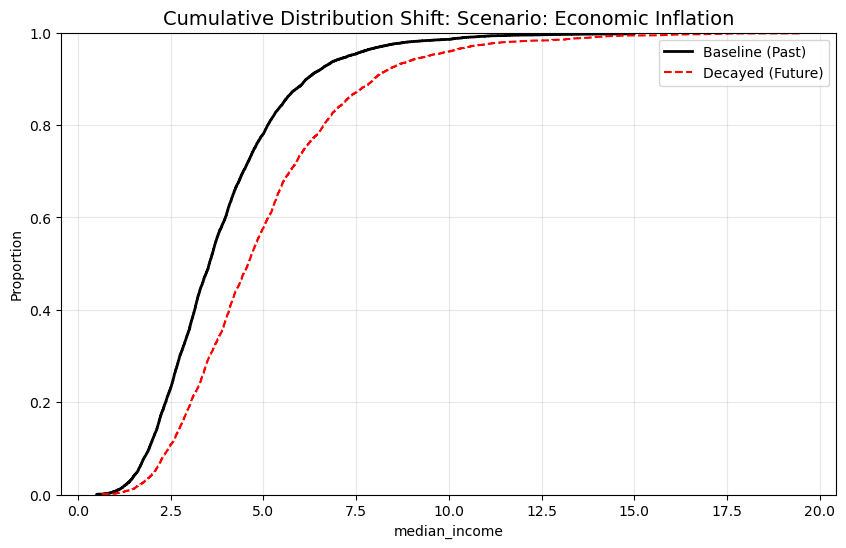

In [3]:
def plot_drift_visual(baseline, decayed, feature_name, title):
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(baseline[feature_name], label='Baseline (Past)', color='black', lw=2)
    sns.ecdfplot(decayed[feature_name], label='Decayed (Future)', color='red', ls='--')
    plt.title(f"Cumulative Distribution Shift: {title}", fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f'../reports/figures/drift_cdf_{feature_name}.png')
    plt.show()

# Visualize the Concept Drift (Inflation)
plot_drift_visual(df_baseline, df_concept, 'median_income', "Scenario: Economic Inflation")

In [4]:
from sklearn.metrics import mean_squared_error
import numpy as np

def check_accuracy_decay(df, model, target='median_house_value'):
    X = df.drop(columns=[target, 'ocean_proximity'])
    y = df[target]
    preds = model.predict(X)
    return np.sqrt(mean_squared_error(y, preds))

rmse_stable = check_accuracy_decay(df_stable, model)
rmse_drift = check_accuracy_decay(df_concept, model)

print(f"📊 ACCURACY DECAY AUDIT:")
print(f" - Baseline RMSE: ${rmse_stable:,.2f}")
print(f" - Decayed RMSE: ${rmse_drift:,.2f}")
print(f" - Error Increase: {((rmse_drift/rmse_stable)-1)*100:.2f}%")

📊 ACCURACY DECAY AUDIT:
 - Baseline RMSE: $49,135.95
 - Decayed RMSE: $76,565.95
 - Error Increase: 55.82%
